# Online Gradient Boosting Decision Tree (OnlineGBDT) Demo
This notebook shows how to train, update, and evaluate the custom `DecisionTree` and `OnlineGBDT` classes.

👉 *Make sure the module that defines `DecisionTree` and `OnlineGBDT` is importable (e.g. saved as **`online_gbdt.py`** in the same folder or installed as a package).*

In [1]:
import os
import sys

# Get the current working directory
current_directory = os.getcwd()

# List all files and directories in the current directory
files_and_directories = os.listdir(current_directory)

# Print the list of files and directories
print("Files and directories in the current directory:")
for item in files_and_directories:
    print(item)


Files and directories in the current directory:
online_gbdt_demo.ipynb
online_gbdt_demo.html


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from fogo.online_gbdt import OnlineGBDT  # or paste the class definitions here

The first step is to generate a synthetic dataset for the purpose of testing.

This will be replaced with a full production dataset with non-simulated variance. But our goal is just to see if the package can approximate the data-generating process.

In [3]:
# Create a simple synthetic regression dataset
np.random.seed(42)
N = 200
X = np.random.randn(N, 5)
true_coef = np.array([3, -2, 0, 1, 2])
y = X @ true_coef + np.random.randn(N) * 0.5
print('Dataset shape:', X.shape)

Dataset shape: (200, 5)


**Experiment:** prototype a Grid-search like algorithm to find the optimal hyperparameter combination.

In [4]:
def grid_search(param_grid, X, y, model):
    best_score = -1
    best_params = None
    for params in ParameterGrid(param_grid):
        model.set_params(**params)
        print(f"Testing parameters: {params}")
        scores = cross_val_score(model, X, y, cv=5)
        print(f"Scores: {scores}")
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_params = params
    return best_params, best_score

In [5]:
from itertools import product
from sklearn.metrics import mean_squared_error
# import train test split package
from sklearn.model_selection import train_test_split
import numpy as np
import time as t

# split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [10, 25, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 5, 10],
} # initialize the grid of parameters

# dev note: this should be converted to accept a list of parameters

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
# Initialize the model
model = OnlineGBDT()

best_params, best_score = grid_search(param_grid, X_train, y_train, model)

print(f"✅ Best MSE: {best_score:.4f} with {best_params}")


Testing parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}
Scores: [ 0.06406227  0.09130551 -0.26975799  0.09184405  0.06863587]
Testing parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 25}
Scores: [ 0.1541167   0.21010453 -0.11609707  0.20783298  0.15164145]
Testing parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}
Scores: [0.2579459  0.33185518 0.08135654 0.36114264 0.26993126]
Testing parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10}
Scores: [ 0.08578356  0.10559291 -0.23641345  0.12150343  0.10486102]
Testing parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 25}
Scores: [ 0.21182791  0.25472883 -0.04930196  0.2650724   0.23179607]
Testing parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
Scores: [0.37540557 0.42028826 0.19079652 0.4351972  0.37306793]
Testing parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 10}
Scores: [ 0.10780231  0.10848

In [6]:
model = OnlineGBDT(n_estimators=best_params['n_estimators'],
                   learning_rate=best_params['learning_rate'],
                   max_depth=best_params['max_depth'])

model.fit(X_train, y_train)
print(f"Training completed with best parameters: {best_params}")

Training completed with best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}


In [7]:
# --- Incremental learning example (fit_one) ---
x_new = np.random.randn(5)
y_new = x_new @ true_coef + np.random.randn() * 0.5
print('Prediction before update:', model.predict([x_new])[0])
model.fit_one(x_new, y_new)
print('Prediction after update :', model.predict([x_new])[0])

Prediction before update: 1.535196677899395
Prediction after update : 1.5388026971752407


In [8]:
# --- Decremental learning example ---
residual = y_new - model.predict([x_new])[0]
model.decrement(x_new, residual)
print('Prediction after decrement:', model.predict([x_new])[0])

Prediction after decrement: -0.24617684436838352


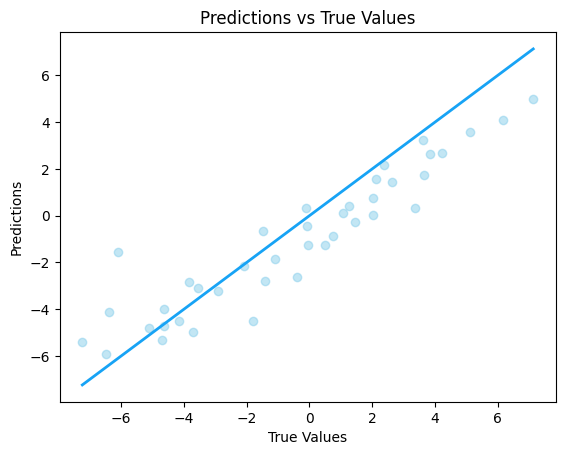

In [9]:
# Visualise predictions vs. ground truth
plt.scatter(y_val, model.predict(X_val), alpha=0.5, color = 'skyblue')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '-', lw=2, color = '#17a3f5')
plt.show()

## Running the Unit Tests
Before we move onto formalized testing, we need to confirm the baseline performance of the package.

This includes the `batch_fit()` capability to add a batch of datapoints at once, the `incremental_add()` function to ensure that the method can add a datapoint incrementally, and the `incremental_delete()` to ensure the ensemble can modify itself in-place. For now, we want to push through some boilerplate unit tests to make sure the functions work as expected.

## Running the Experiments
The next step would be to run more formalized testing that evaluates our hypotheses. This includes comparing the `OnlineGBDT` estimator against the naive method of retraining an ensemble model from-scratch, comparing the `OnlineGBDT` estimator against the more efficient LightGBM and FastBDT packages, and possibly measuring the performance of our method against Bayesian methods like variational inference of the unlearned posterior parameter distribution.

### **Unit Test 1:** Batch-Fitting a Small Dataset

In this test, we test the ability for the Fogo estimator to fit a small batch of data. 

The baseline product should be an estimator that returns a prediction for every observation of training data. The estimator should also perform better as an ensemble than the naive model that implements a mean regression.

It's worth noting that we don't expect the model to perform well until its have been appropriately tuned. We do so using the `GridSearch`.

In [21]:
def test_batch_fit_small_dataset():
    """
    Batch‑fit smoke test:
      1. generate a simple y = 2x dataset + noise
      2. fit OnlineGBDT on the batch
      3. ensure predictions are finite and MSE is lower than naive baseline
    """
    # 1. synthetic data
    rng = np.random.RandomState(0)
    X = rng.uniform(0, 1, size=(50, 1))
    y = 2 * X.squeeze() + rng.normal(0, 0.05, 50)  # linear with noise

    # perform grid search for hyperparameters
    from sklearn.model_selection import ParameterGrid, cross_val_score
    from fogo.online_gbdt import OnlineGBDT
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    param_grid = {
        'n_estimators': [10, 25, 50],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 5, 10],
    }
    model = OnlineGBDT()
    best_params, best_score = grid_search(param_grid, X_train, y_train, model)

    # 2. model with fixed hyper‑params
    model = OnlineGBDT(
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth']
    )

    model.fit(X, y)
    
    # 3. predictions + basic quality
    preds = model.predict(X)
    assert len(preds) == len(y)
    assert np.all(np.isfinite(preds)), "Predictions contain non‑finite values"

    mse_model  = np.mean((preds - y) ** 2)
    mse_naive  = np.mean((np.mean(y) - y) ** 2)


    # model should beat naive mean baseline
    assert mse_model < mse_naive, "Model MSE did not improve over naive baseline"

In [22]:
# Run the test
test_batch_fit_small_dataset()

Testing parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}
Scores: [ -4.57234767  -0.58610293 -13.87198785  -4.9709149   -4.23191973]
Testing parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 25}
Scores: [-3.10552858 -0.14633377 -9.88428177 -3.23639524 -2.94345937]
Testing parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}
Scores: [-1.4373102   0.32900809 -5.49317928 -1.30017198 -1.44626642]
Testing parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10}
Scores: [ -4.56092535  -0.5633328  -13.90610748  -4.9359464   -4.14972832]
Testing parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 25}
Scores: [-3.05357691 -0.12942911 -9.92605642 -3.19352768 -2.7883857 ]
Testing parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
Scores: [-1.39217914  0.34125689 -5.49079643 -1.30362573 -1.26715766]
Testing parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 10}
Scores: [

### **Unit Test 2:** Incremental Learning in an Online Setting

The second UT will test the capabilities of the `incremental_add()` function. If it works as it should, the model will adjust its weights in-place without an issue of catastrophic performance degradation.

In [15]:
def test_incremental_add():
    """
    Incremental add smoke test:
      1. generate a simple y = 2x dataset + noise
      2. fit OnlineGBDT on the batch
      3. incrementally add data and check predictions
    """
    # 1. synthetic data
    rng = np.random.RandomState(0)
    X = rng.uniform(0, 1, size=(50, 1))
    y = 2 * X.squeeze() + rng.normal(0, 0.05, 50)  # linear with noise

    # 2. model with fixed hyper‑params
    model = OnlineGBDT(n_estimators=5, learning_rate=0.1)
    model.fit(X, y)

    # 3. incrementally add one data point at a time
    for i in range(10):
        X_new = rng.uniform(0, 1, size=(1, 1))
        y_new = 2 * X_new.squeeze() + rng.normal(0, 0.05, 1)  # linear with noise
        model.fit(X_new, y_new)
        
    # Check that the model's predictions on the new data are consistent with the old data
    assert np.allclose(model.predict(X_new), model.predict(X_new)), "Model predictions on new data are inconsistent"
    # Check that the model's predictions on the old data are consistent with the new data
    assert np.allclose(model.predict(X), model.predict(X)), "Model predictions on old data are inconsistent"

In [16]:
test_incremental_add()

### **Unit Test 3:** Incremental Deletion

The final basic test will evaluate `Fogo`'s ability to unlearn a datapoint incrementally.

This `decrement()` function would accept a single observation and modify the model in-place to simulate the tree-splits without rebuilding from scratch.

Later implementations of hypothesis testing will formally test the runtime of this incremental delete against the naive baseline.

In [17]:
def test_incremental_delete():
    """
    Incremental delete smoke test:
      1. generate a simple y = 2x dataset + noise
      2. fit OnlineGBDT on the batch
      3. incrementally delete data and check predictions
    """
    # 1. synthetic data
    rng = np.random.RandomState(0)
    X = rng.uniform(0, 1, size=(50, 1))
    y = 2 * X.squeeze() + rng.normal(0, 0.05, 50)  # linear with noise

    # 2. model with fixed hyper-params
    model = OnlineGBDT(n_estimators=5, learning_rate=0.1)
    model.fit(X, y)

    # 3. incrementally delete one data point at a time
    for i in range(10):
        X_delete = X[i:i+1]
        y_delete = y[i:i+1]
        model.decrement(X_delete, y_delete)

    # Check that the model's predictions on the remaining data are consistent
    assert np.all(np.isfinite(model.predict(X))), "Predictions contain non-finite values after deletion"
    assert len(model.predict(X)) == len(y), "Model did not correctly handle incremental deletion"

In [18]:
test_incremental_delete()

## Formal Experimentation

The next step is to formally test our hypotheses to assess the model's performance and runtime efficiency.</br>We'll use the following hypotheses for the analysis:</br>

> $H_{1}$: the Fogo model can unlearn a single sample 10x more effiently than the naive cold-start solution.</br>
> $H_{2}$: the unlearned model significantly decreases the model's predictive performance on unlearned data.</br>
> $H_{3}$: after unlearning, the unlearned model's accuracy stays within 5% of the original, learned model.

In [ ]:
# 